In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Super resolution data

In [2]:
from fastai.conv_learner import *
from pathlib import Path
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imagenet')
PATH_TRN = PATH/'train'

In [4]:
fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5],label_arr_full[:5]))

[('n01440764/n01440764_9627.JPEG', 0),
 ('n01440764/n01440764_9609.JPEG', 0),
 ('n01440764/n01440764_5176.JPEG', 0),
 ('n01440764/n01440764_6936.JPEG', 0),
 ('n01440764/n01440764_4005.JPEG', 0)]

In [5]:
all_labels[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [6]:
np.random.seed(42)
keep_pct = 1.
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [7]:
arch = vgg16
sz_hr,sz_lr = 288,72
bs = 24

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [9]:
aug_tfms = [RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.1, 0.2, tfm_y=TfmType.PIXEL)]

In [10]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(12811, 1268356)

In [11]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr, norm_y=False)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [12]:
denorm = md.trn_ds.denorm

In [13]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx], interpolation="bilinear")
    ax.axis('off')

In [14]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([24, 3, 72, 72]), torch.Size([24, 3, 288, 288]))

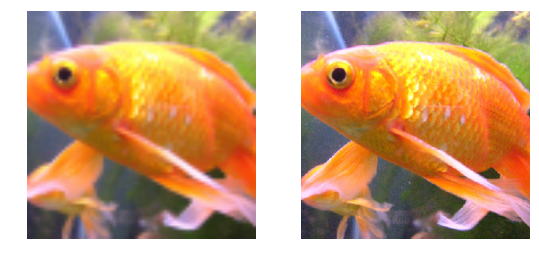

In [15]:
idx=15
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1], normed=False)

In [16]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

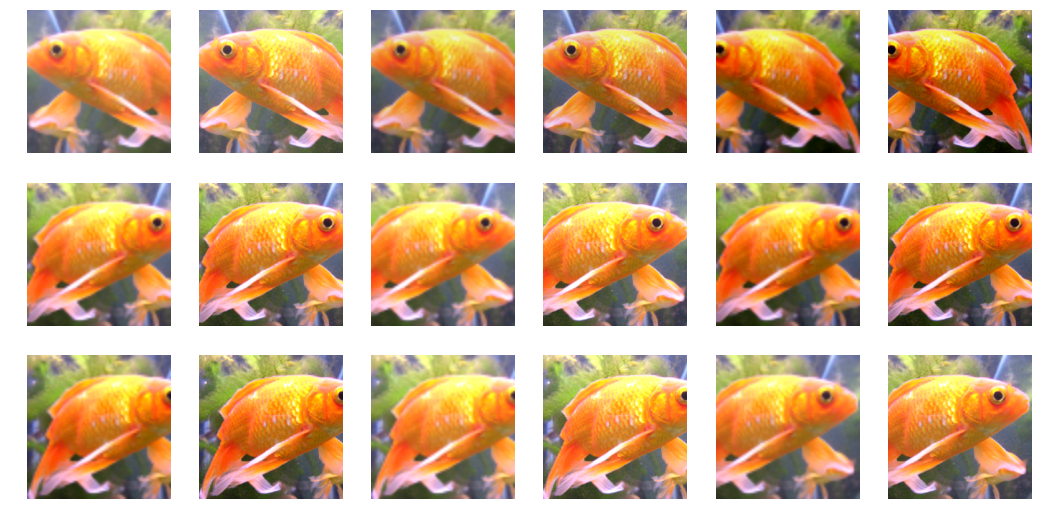

In [17]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2])
    show_img(y,idx, ax=axes.flat[i*2+1], normed=False)

## Model

In [14]:
def conv_bn_relu(ni, nf, kernel_size=3, bias=False, actn=True):
    pad = kernel_size//2
    layers = [
        nn.ReflectionPad2d(pad),
        nn.Conv2d(ni, nf, kernel_size, padding=0, bias=bias),
        nn.BatchNorm2d(nf)
    ]
    if actn: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

In [15]:
class ResSequential(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x)

In [16]:
def res_block(nf):
    return ResSequential(
        conv_bn_relu(nf, nf),
        conv_bn_relu(nf, nf, actn=False))

In [17]:
def upsample():
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        conv_bn_relu(64, 64))

In [18]:
class SrResnet(nn.Module):
    def __init__(self):
        super().__init__()
        features = [conv_bn_relu(3, 64, 9)]
        for i in range(4): features.append(res_block(64))
        features += [
            upsample(), upsample(),
            nn.ReflectionPad2d(4),
            nn.Conv2d(64, 3, kernel_size=9, bias=True, padding=0)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return F.sigmoid(self.features(x))

## Pixel loss

In [89]:
m = to_gpu(SrResnet())

In [90]:
m = nn.DataParallel(m, [0,2])

In [91]:
learn = Learner(md, SingleModel(m), opt_fn=opt_fn)
learn.crit = F.mse_loss

A Jupyter Widget

 20%|██        | 292/1428 [00:41<02:39,  7.12it/s, loss=0.0663]

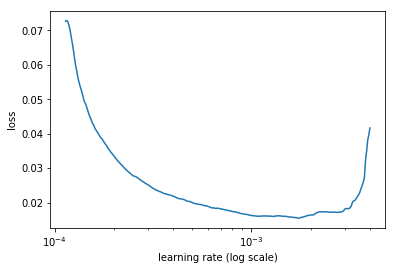

In [93]:
learn.lr_find(start_lr=1e-4, end_lr=10000)
learn.sched.plot()

In [94]:
lr=1e-3

In [95]:
learn.fit(lr, 1, cycle_len=1, use_clr_beta=(40,10))

A Jupyter Widget

  1%|          | 16/1428 [00:03<04:49,  4.87it/s, loss=0.0777] 
epoch      trn_loss   val_loss                                  
    0      0.011023   0.008901  



[array([0.0089])]

In [133]:
x,y = next(iter(md.val_dl))
preds = learn.model(VV(x))

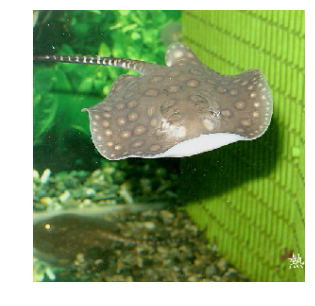

In [134]:
show_img(y,idx,normed=False)

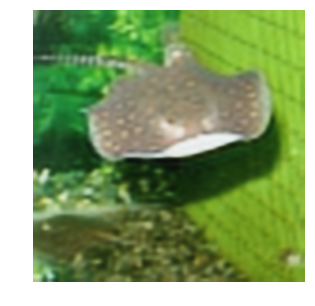

In [129]:
show_img(preds,idx,normed=False);

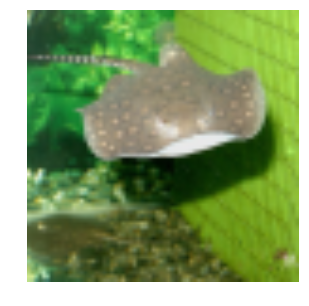

In [130]:
show_img(x,idx);

## Perceptual loss

In [19]:
m_vgg = vgg16(True)

In [20]:
blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks

[5, 12, 22, 32, 42]

In [21]:
[m_vgg[i] for i in blocks]

[ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)]

In [22]:
m_vgg = nn.Sequential(*children(m_vgg)[:23]).cuda().eval()
set_trainable(m_vgg, False)

In [23]:
def flatten(x): return x.view(x.size(0), -1)

In [24]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [25]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res = [F.mse_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [26]:
m = to_gpu(SrResnet())
m = nn.DataParallel(m, [0,2])

learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [27]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

A Jupyter Widget

  2%|▏         | 9/481 [00:05<04:46,  1.65it/s, loss=0.00952] 
epoch      trn_loss   val_loss                                 
    0      0.009885   0.00987   



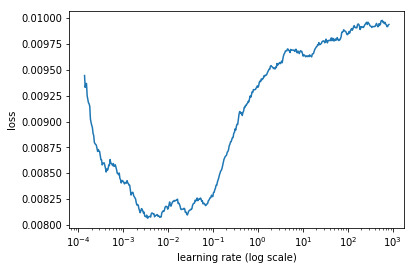

In [38]:
learn.lr_find(1e-4, 1000)
learn.sched.plot()

In [28]:
lr=2e-3
wd=1e-7

In [38]:
learn.load('sr-samp0')

In [29]:
learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr=(20,40,0.95,0.85))

A Jupyter Widget

epoch      trn_loss   val_loss                                         
    0      0.005649   0.005913  



[array([0.00591])]

In [30]:
learn.save('sr-samp0')

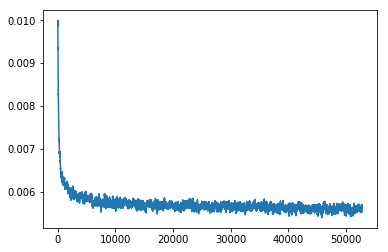

In [31]:
learn.sched.plot_loss()

In [ ]:
learn.fit(lr/10, 1, cycle_len=1, wds=wd, use_clr=(20,40,0.95,0.85))

A Jupyter Widget

 21%|██        | 11064/52849 [1:28:29<5:34:13,  2.08it/s, loss=0.00557]

In [ ]:
learn.save('sr')

In [28]:
learn.load('sr')

In [ ]:
def plot_ds_img(idx, ax=None, figsize=(7,7), normed=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    im = md.val_ds[idx][0]
    if normed: im = denorm(im)[0]
    else:      im = np.rollaxis(to_np(im),0,3)
    ax.imshow(im, interpolation="bilinear")
    ax.axis('off')

In [ ]:
fig,axes=plt.subplots(8,4,figsize=(12,24))
for i,ax in enumerate(axes.flat): plot_ds_img(i+156,ax=ax, normed=True)

In [97]:
x,y=md.val_ds[183]

In [98]:
y=y[None]

In [99]:
learn.model.eval()
preds = learn.model(VV(x[None]))

In [34]:
learn.crit(preds, V(y), sum_layers=False)

TypeError: mse_loss() got an unexpected keyword argument 'sum_layers'

In [ ]:
learn.crit.close()

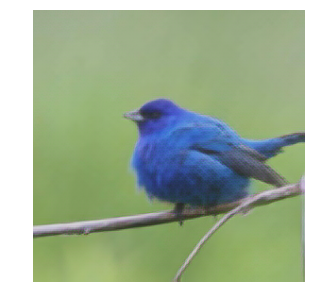

In [100]:
show_img(preds,0, normed=False)

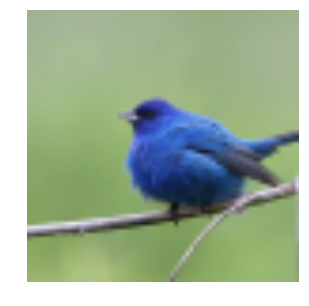

In [101]:
show_img(x[None],0)

In [102]:
def nrm_y(y):
    y = np.rollaxis(y,1,4)
    y,_ = tfms[1].norm(y)
    return np.rollaxis(y,3,1)

In [103]:
preds = learn.model(VV(nrm_y(y)))

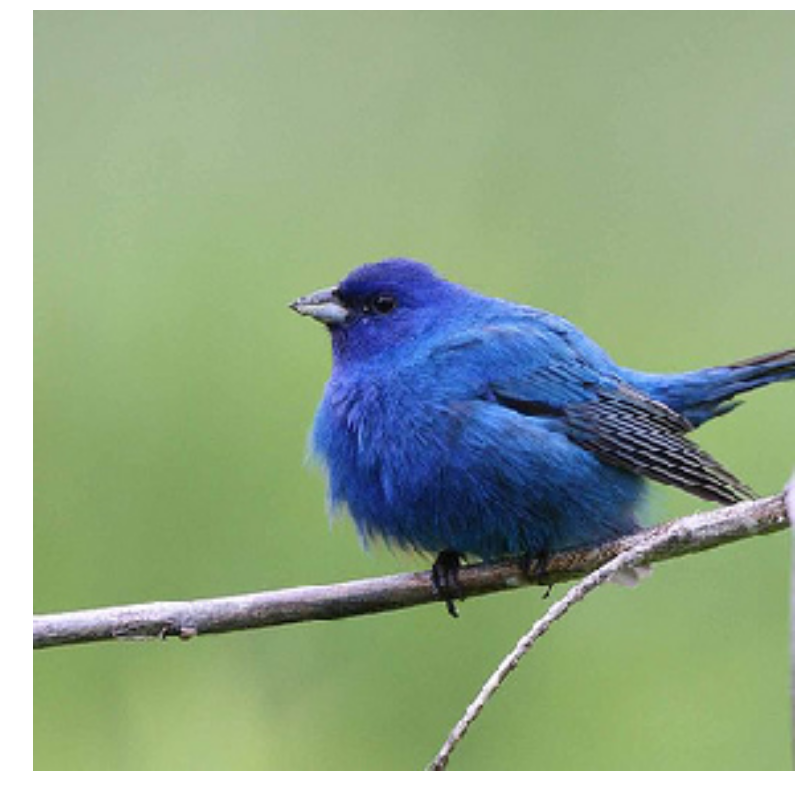

In [104]:
show_img(y,0, figsize=(14,14), normed=False)

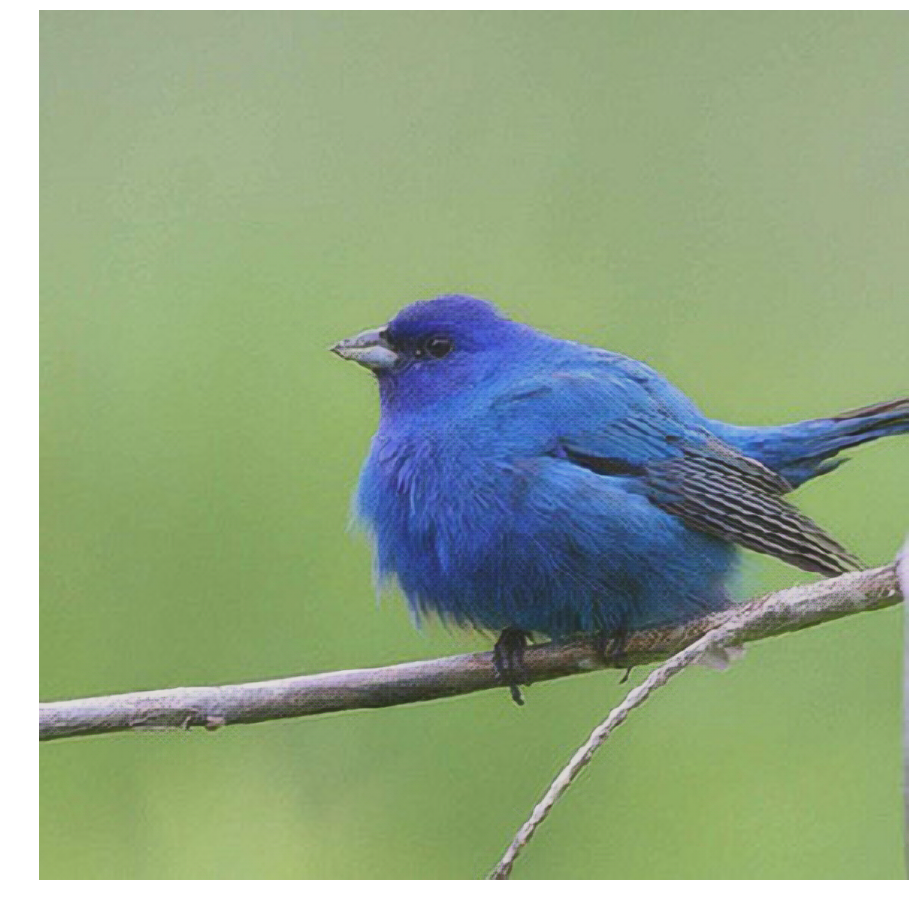

In [105]:
show_img(preds,0, figsize=(16,16), normed=False)

In [55]:
learn.save('sr')